# IU DeepNLP Reading Group Meeting #4
## PyTorch Tutorial

In [5]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor as T
from torch.autograd import Variable as V
from torch.utils import data
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# Task 1b- Train NLLM on more data!

In [140]:
#Downloading sample data for character level RNN
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2017-10-13 07:26:55--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.184.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.184.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

100%[======================================>] 1,115,394   1.44MB/s   in 0.7s   

2017-10-13 07:26:56 (1.44 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [34]:
class ShakespeareDataset(data.Dataset):
    def __init__(self, file):
        sentence_raw= open(file, 'r').read().split()

        self.vocab= set(sentence_raw)
        self.vocab_dict= {word:i for i,word in enumerate(self.vocab)}
        self.vocab_inv_dict= {i:word for word,i in self.vocab_dict.items()}
        
        #converting to word ids is easier when feeding to model
        sentence= list(map(lambda word:self.vocab_dict[word], sentence_raw))
        
        self.trigrams= [([sentence[i], sentence[i+1]], sentence[i+2]) for i in range(len(sentence)- 2)]
        inputs,targets= zip(*self.trigrams)
        self.inputs= torch.from_numpy(np.array(inputs)) #try longtensor?
        self.targets= torch.from_numpy(np.array(targets))
    
    def __len__(self):
        return len(self.trigrams)
        
    def __getitem__(self,idx):
        return self.inputs[idx], self.targets[idx]
        
textdata= ShakespeareDataset('input.txt')
print(textdata[10])

#Alternate way to use DataLoader using TensorDataset
#inp= textdata.inputs
#targets= textdata.targets
#tensortextdata= torch.utils.data.TensorDataset(inp,targets)
#dataloader= torch.utils.data.DataLoader(tensortextdata, batch_size=10, shuffle=True,)
dataloader= data.DataLoader(textdata, batch_size=150, shuffle=True,)
for sample_batch in dataloader:
    x,y= sample_batch
    print(x.size(),y.size())
    break

(
 21989
 23498
[torch.LongTensor of size 2]
, 15961)
torch.Size([150, 2]) torch.Size([150])


In [37]:
#Hyperparams
CONTEXT_SIZE = 2
EMBEDDING_DIM = 50
VOCAB_SIZE= len(textdata.vocab)

class NLLM(nn.Module):
    #Actual Network code. Easy as pie!
    def __init__(self, vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, context_size=CONTEXT_SIZE):
        super(NLLM, self).__init__()
        self.emb= nn.Embedding(vocab_size,embedding_dim)
        self.linear1=nn.Linear(context_size*embedding_dim,200)
        self.linear2=nn.Linear(200,vocab_size)
    
    def forward(self,inputs):
        #Remember that inputs are minibatched
        batch_size= inputs.size()[0]
        
        h= self.emb(inputs) #Functions like a dictionary. Given inputs, returns corresponding embeddings
        #Input: LongTensor (N, W), N = mini-batch, W = number of indices to extract per mini-batch
        #Output: (N, W, embedding_dim)
        
        h= h.view(batch_size,-1) #This reshapes batch*2*10 into batch*20. -1 tells Pytorch to calculate dimensions given constraints
        h= F.relu(self.linear1(h))
        out= F.relu(self.linear2(h))
        logprobs= F.log_softmax(out)
        
        return logprobs

In [38]:
#Testing
x,y= None,None
for batch in dataloader:
    x,y= batch
    break
    
print(x.size())
model= NLLM()
print(model.forward(V(x)).size())


torch.Size([150, 2])
torch.Size([150, 25670])


In [39]:
EPOCHS=10

model= NLLM()
#Hooking up the optimizer to the net's parameters. We will use this later to update
optimizer= optim.SGD(model.parameters(),lr=0.01) 
loss_criterion= nn.NLLLoss() #Negative log likelihood

losses=[]

for i in range(EPOCHS):
    total_loss=0
    for context,targets in dataloader:
        #turn data into Autograd variables
        context= V(context)
        targets= V(targets)
        
        log_probs= model(context)

        loss= loss_criterion(log_probs,targets) 
        loss.backward()
        optimizer.step()
        
        total_loss+= loss.data.numpy() #Autograd var->Tensor->Numpy
    losses.append(total_loss)
    print(f"\rLoss at epoch {i+1}:{total_loss}",end='')
    
#Too slow. Let's use the GPU!

KeyboardInterrupt: 

https://discuss.pytorch.org/t/solved-make-sure-that-pytorch-using-gpu-to-compute/4870/2

generally speaking, the pattern is:
- use .cuda() on any input batches/tensors
- use .cuda() on your network module, which will hold your network, like:

```
class MyModel(nn.Module):
    def __init__(self):
        self.layer1 = nn. ...
        self.layer2 = nn. ...
        ... etc ...
```
then just do:

```
model = MyModel()
model.cuda()
```

In [13]:
torch.cuda.is_available()

True

In [46]:
EPOCHS=10

model= NLLM()
model.cuda()

#Hooking up the optimizer to the net's parameters. We will use this later to update
#optimizer= optim.SGD(model.parameters(),lr=0.01) 
optimizer= optim.Adam(model.parameters())
loss_criterion= nn.NLLLoss() #Negative log likelihood

losses=[]

for i in range(EPOCHS):
    running_loss=0.0
    for batch_num,(context,targets) in enumerate(dataloader):
        #turn data into Autograd variables
        context= V(context.cuda()) #changing inputs to the net into cuda arrays
        targets= V(targets.cuda())
        
        optimizer.zero_grad() #Remember to clear gradients. They accumulate
        
        
        log_probs= model(context)

        loss= loss_criterion(log_probs,targets) 
        
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]

    print(f"\rLoss at epoch {i+1}:{running_loss}",end='')
    losses.append(running_loss)
    
#Too slow. Let's use the GPU!

Loss at epoch 10:11112.149080753326

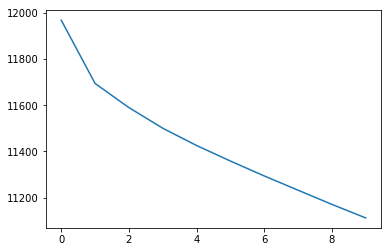

In [47]:
plt.plot(losses)

In [75]:
#Sample data using the model

def generate(priming_words, model, dataset, length):
    """
    args:
        priming words is the first input fed to the language model
        model is the language model you're using
        length of generated sequence
    returns
    """
    context= priming_words.split()
    context= list(map(lambda word:dataset.vocab_dict[word], context))
    sentence= context[:]
    
    context= torch.LongTensor(context)
    context=context.unsqueeze(0)
    
    for i in range(length):
        #print(context)
        inp= V(context.cuda())
        log_probs= model(inp)

        _,argmax= torch.max(log_probs,1) #get index
        next_word= argmax.data[0]
        #How to sample from a softmax?
        
        sentence.append(next_word)
        
        context[0,0]=context[0,1]
        context[0,1]=next_word
    
    sentence= list(map(lambda word:dataset.vocab_inv_dict[word], sentence))
    return " ".join(sentence)

generate("You are", model, textdata, 10)

'You are a poor a poor a poor a poor a poor'